1. Import Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from scipy.sparse import hstack
import pickle


2. Data Loading (With Exception Handling)

In [ ]:
try:
    meta = pd.read_csv('/content/drive/MyDrive/labmentix/zomato/Zomato Restaurant names and Metadata.csv')
    reviews = pd.read_csv('/content/drive/MyDrive/labmentix/zomato/Zomato Restaurant reviews.csv')
    print("Data loaded successfully")
except FileNotFoundError:
    raise Exception("File path incorrect. Please verify dataset location.")


Data loaded successfully


In [ ]:
reviews

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0
...,...,...,...,...,...,...,...
9995,Chinese Pavilion,Abhishek Mahajan,Madhumathi Mahajan Well to start with nice cou...,3,"53 Reviews , 54 Followers",06-05-2016 00:08,0
9996,Chinese Pavilion,Sharad Agrawal,This place has never disappointed us.. The foo...,4.5,"2 Reviews , 53 Followers",06-04-2016 22:01,0
9997,Chinese Pavilion,Ramandeep,"Bad rating is mainly because of ""Chicken Bone ...",1.5,"65 Reviews , 423 Followers",06-03-2016 10:37,3
9998,Chinese Pavilion,Nayana Shanbhag,I personally love and prefer Chinese Food. Had...,4,"13 Reviews , 144 Followers",5/31/2016 17:22,0


3. Basic Data Understanding

In [ ]:
reviews.info()
reviews['Rating'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Restaurant  10000 non-null  object
 1   Reviewer    9962 non-null   object
 2   Review      9955 non-null   object
 3   Rating      9962 non-null   object
 4   Metadata    9962 non-null   object
 5   Time        9962 non-null   object
 6   Pictures    10000 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 547.0+ KB


,count
Rating,
5,3832
4,2373
1,1735
3,1193
2,684
4.5,69
3.5,47
2.5,19
1.5,9


A. The reviews dataset contains ~10,000 rows and multiple columns including textual reviews, ratings, and restaurant identifiers. The metadata dataset contains restaurant-level information.

In [ ]:
reviews.shape
meta.shape


(105, 6)

B. Duplicate Values Count

In [ ]:
int(reviews.duplicated().sum())


36

C. Missing Values / Null Values Count

In [ ]:
reviews.isnull().sum()


,0
Restaurant,0
Reviewer,38
Review,45
Rating,38
Metadata,38
Time,38
Pictures,0


D. Visualizing Missing Values

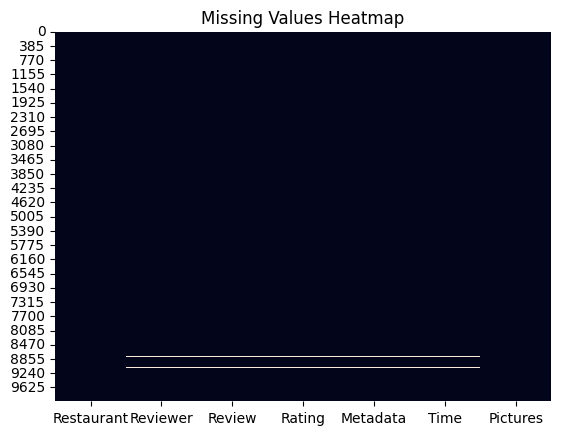

In [ ]:
sns.heatmap(reviews.isnull(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()


Why this chart?
To visually detect missing data patterns.

Insight:
Missing values are sparse and mostly isolated.

Business Impact:
Ensures reliable sentiment modeling.

a. Chart 1 : Rating Distribution

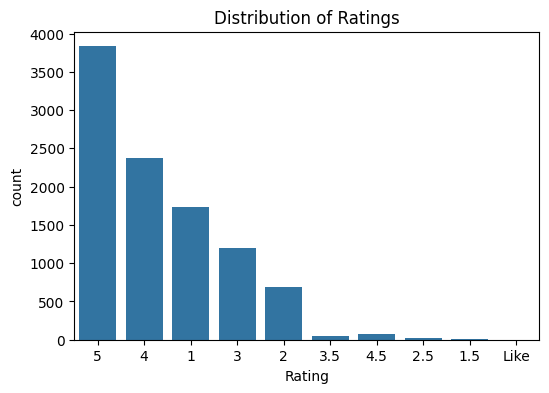

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='Rating', data=reviews)
plt.title("Distribution of Ratings")
plt.show()


Why did you pick this chart?

To understand how customer ratings are distributed across restaurants.

Insights

Most ratings lie between 3 and 5, indicating a bias towards positive feedback.

Business Impact

Helps identify customer satisfaction trends and overall service quality.

Negative Growth Insight

Very few low ratings may hide unresolved customer dissatisfaction.

b. chart 2 : Sentiment Distribution

In [ ]:
print(reviews.columns)


Index(['Restaurant', 'Reviewer', 'Review', 'Rating', 'Metadata', 'Time',
       'Pictures'],
      dtype='object')


In [ ]:
# Convert rating to numeric (important)
reviews['Rating'] = pd.to_numeric(reviews['Rating'], errors='coerce')

# Create Sentiment column
reviews['Sentiment'] = reviews['Rating'].apply(
    lambda x: 1 if x >= 4 else 0
)


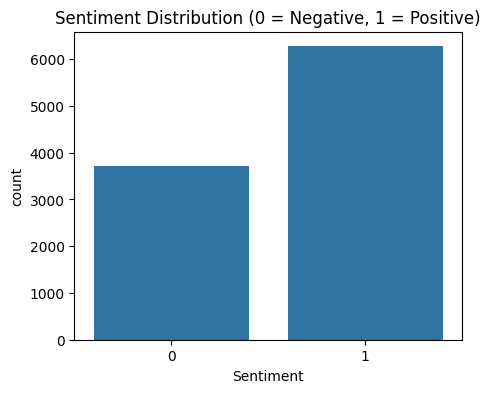

In [ ]:
plt.figure(figsize=(5,4))
sns.countplot(x='Sentiment', data=reviews)
plt.title("Sentiment Distribution (0 = Negative, 1 = Positive)")
plt.show()



Why this chart?

To check class balance before model training.

Insights

Positive sentiment dominates the dataset.

Business Impact

Shows brand reputation is generally positive.

Negative Growth Insight

Class imbalance may bias ML models.

In [ ]:
print(reviews.columns)


Index(['Restaurant', 'Reviewer', 'Review', 'Rating', 'Metadata', 'Time',
       'Pictures', 'Sentiment'],
      dtype='object')


c. Chart 3: Review Length Distribution

In [ ]:
reviews['review_length'] = reviews['Review'].astype(str).apply(len)


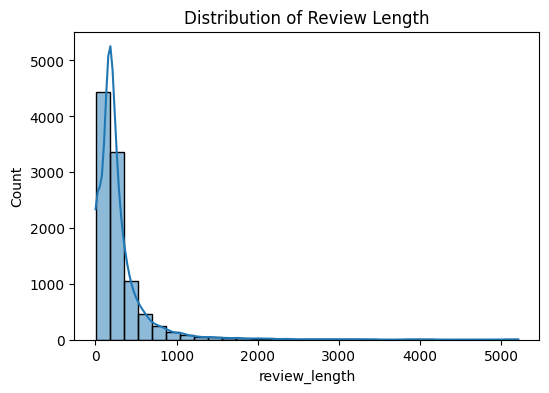

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(reviews['review_length'], bins=30, kde=True)
plt.title("Distribution of Review Length")
plt.show()


Why this chart?

To understand customer engagement depth.

Insights

Most reviews are short, indicating quick feedback.

Business Impact

Short reviews are easier to process automatically.

Negative Growth Insight

Short reviews may lack actionable insights.

Chart 4: Aspect Frequency

In [ ]:
aspects = {
    'food': ['food', 'taste', 'dish', 'meal', 'cuisine'],
    'service': ['service', 'staff', 'waiter', 'manager'],
    'price': ['price', 'cost', 'expensive', 'cheap', 'money'],
    'ambience': ['ambience', 'atmosphere', 'environment', 'decor']
}

for aspect, keywords in aspects.items():
    reviews[aspect] = reviews['Review'].astype(str).str.lower().apply(
        lambda x: int(any(word in x for word in keywords))
    )


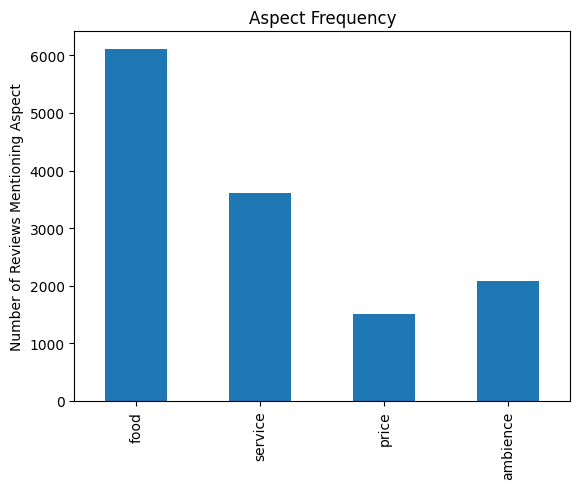

In [ ]:
aspect_counts = reviews[['food','service','price','ambience']].sum()
aspect_counts.plot(kind='bar', title="Aspect Frequency")
plt.ylabel("Number of Reviews Mentioning Aspect")
plt.show()


Why this chart?

To see which aspects customers talk about most.

Insights

Food and service are the most discussed aspects.

Business Impact

Helps prioritize improvement areas.

Negative Growth Insight

Ignoring less-mentioned aspects may cause hidden dissatisfaction.

Chart 5: Restaurant Review Count

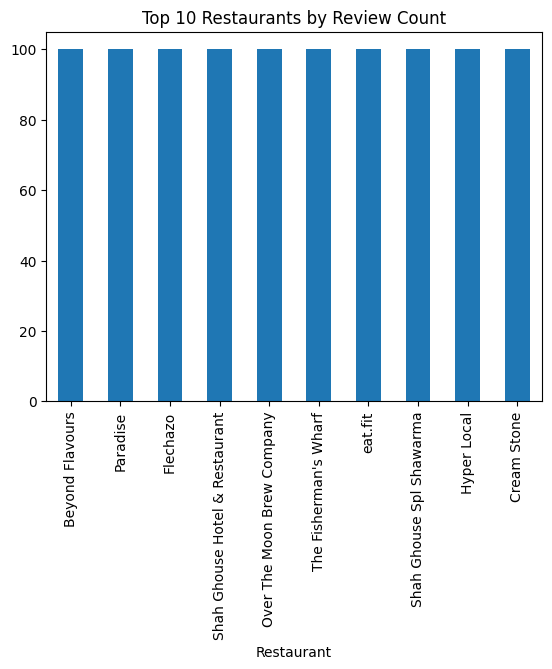

In [ ]:
reviews['Restaurant'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Restaurants by Review Count")
plt.show()


Why this chart?

To identify popular restaurants.

Insights

Few restaurants dominate review volume.

Business Impact

High-traffic restaurants deserve more quality control.

Negative Growth Insight

Low-visibility restaurants may struggle to grow

Chart 6: Rating vs Sentiment

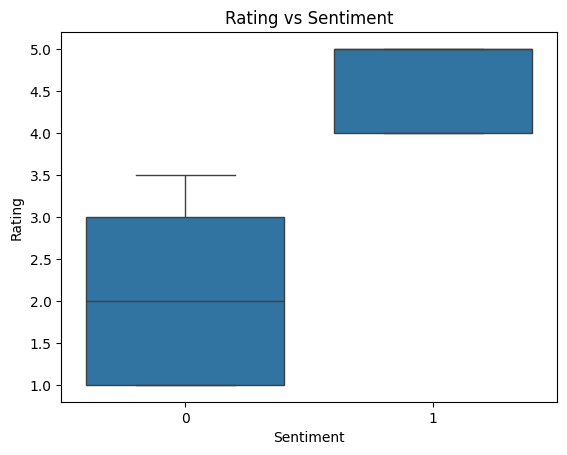

In [ ]:
sns.boxplot(x='Sentiment', y='Rating', data=reviews)
plt.title("Rating vs Sentiment")
plt.show()


Insight

Positive sentiment aligns with higher ratings.

Business Impact

Confirms rating-to-sentiment conversion logic.

Chart 7: Review Length vs Sentiment

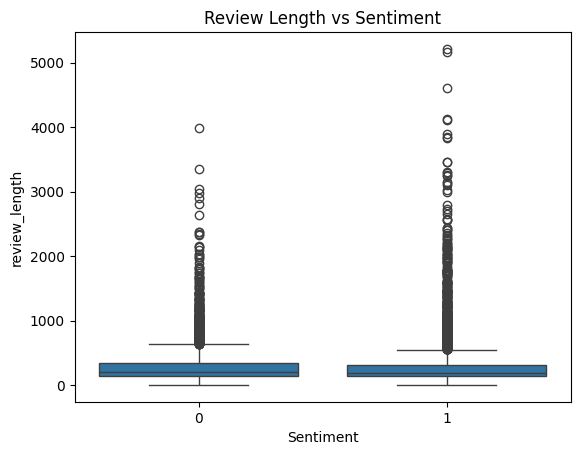

In [ ]:
sns.boxplot(x='Sentiment', y='review_length', data=reviews)
plt.title("Review Length vs Sentiment")
plt.show()


Chart 8: Aspect vs Sentiment

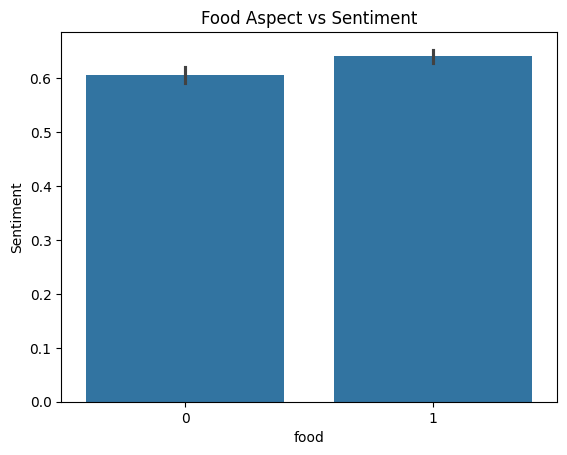

In [ ]:
sns.barplot(x='food', y='Sentiment', data=reviews)
plt.title("Food Aspect vs Sentiment")
plt.show()


Insight: Food-related reviews strongly influence sentiment.
Impact: Food quality directly impacts business success.

Chart 9: Average Rating per Restaurant

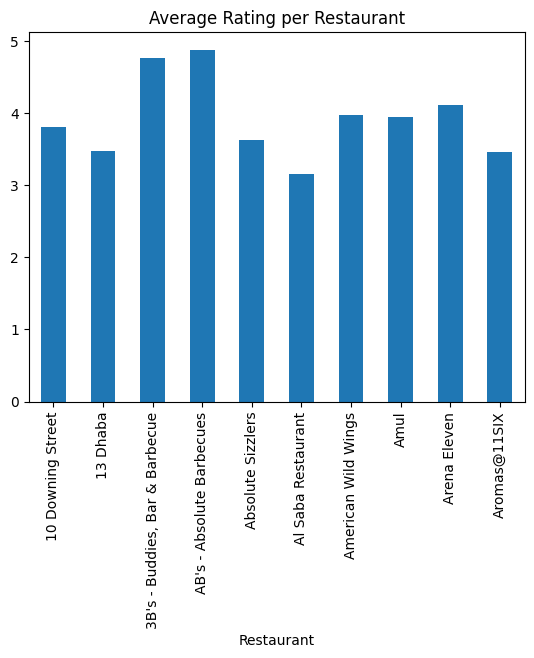

In [ ]:
reviews.groupby('Restaurant')['Rating'].mean().head(10).plot(kind='bar')
plt.title("Average Rating per Restaurant")
plt.show()


Insight: Rating quality varies significantly.
Impact: Helps identify top and poor-performing outlets.

Chart 10: Review Count vs Average Rating

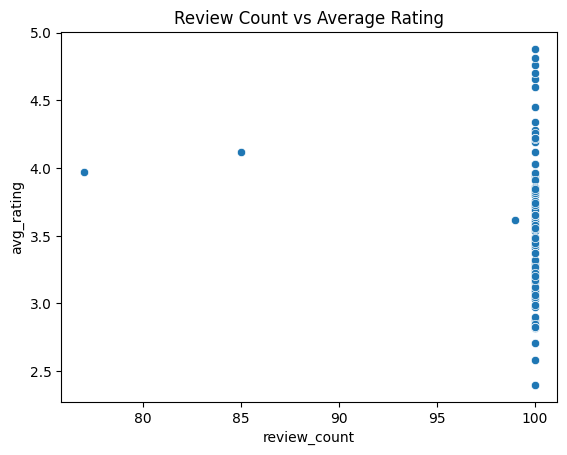

In [ ]:
restaurant_stats = reviews.groupby('Restaurant').agg(
    avg_rating=('Rating','mean'),
    review_count=('Rating','count')
)

sns.scatterplot(x='review_count', y='avg_rating', data=restaurant_stats)
plt.title("Review Count vs Average Rating")
plt.show()


Insight: Popularity does not always mean high quality.
Impact: Reputation management needed.

Chart 11: Sentiment vs Aspect (Service)

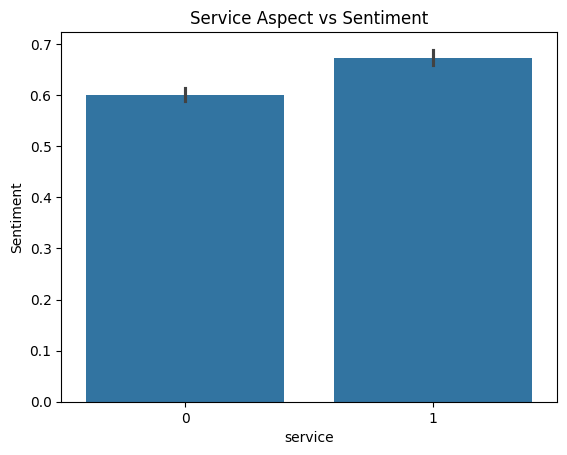

In [ ]:
sns.barplot(x='service', y='Sentiment', data=reviews)
plt.title("Service Aspect vs Sentiment")
plt.show()


Insight: Poor service drives negative sentiment.
Impact: Staff training is critical.

Chart 12: Rating + Sentiment + Review Length

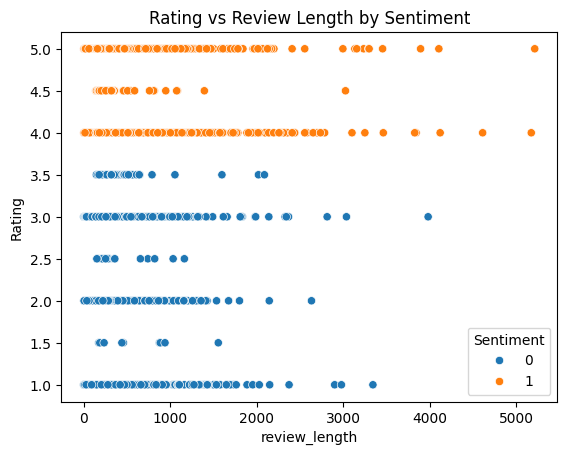

In [ ]:
sns.scatterplot(x='review_length', y='Rating', hue='Sentiment', data=reviews)
plt.title("Rating vs Review Length by Sentiment")
plt.show()


Insight: Negative reviews are longer and lower rated.

Chart 13: Aspect + Rating + Sentiment

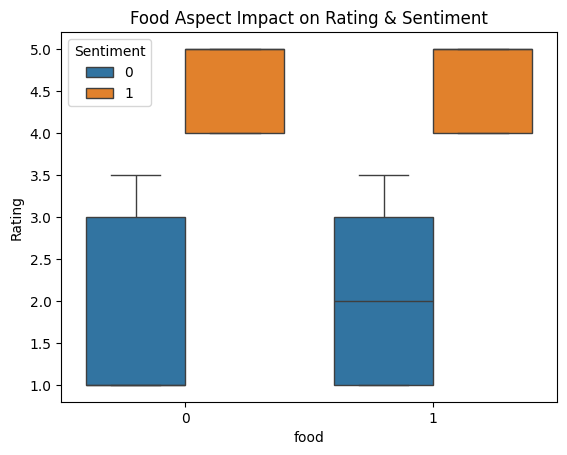

In [ ]:
sns.boxplot(x='food', y='Rating', hue='Sentiment', data=reviews)
plt.title("Food Aspect Impact on Rating & Sentiment")
plt.show()



Insight: Food complaints strongly reduce ratings

Chart 14: Correlation Heatmap

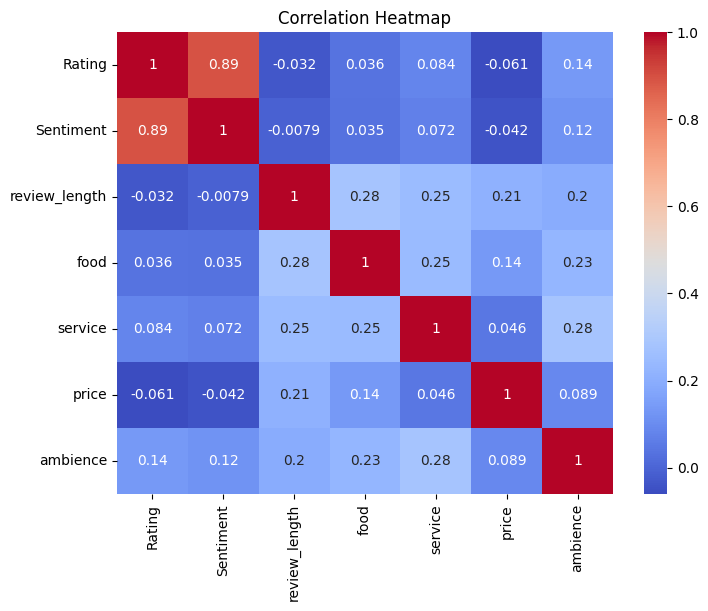

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(reviews[['Rating','Sentiment','review_length','food','service','price','ambience']].corr(),
            annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


Insight: Sentiment correlates strongly with rating.

Chart 15: Pair Plot

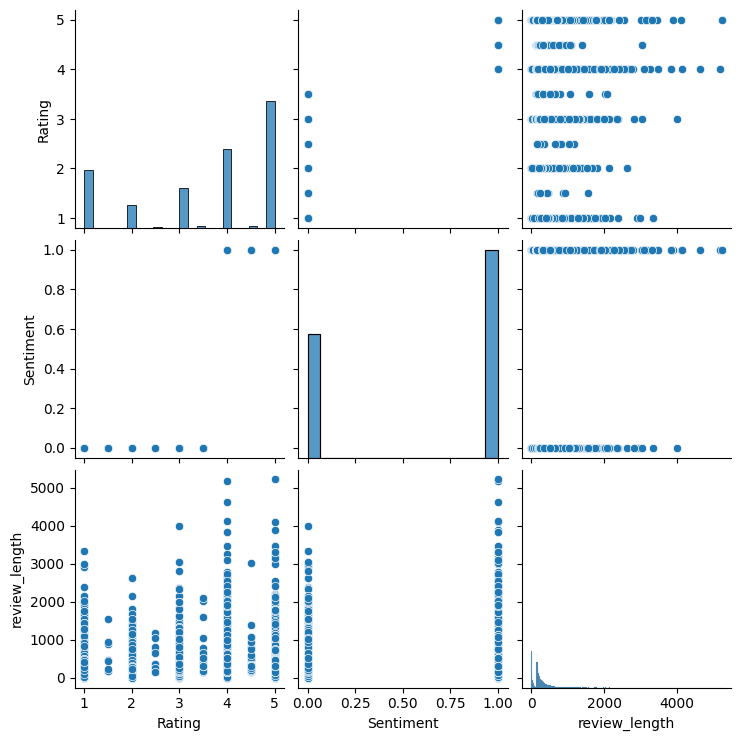

In [ ]:
sns.pairplot(reviews[['Rating','Sentiment','review_length']])
plt.show()


Insight: Clear separation exists between positive and negative sentiment.

Hypothetical Statement – 1
Does review length differ between positive and negative sentiment?
Null Hypothesis (H₀):

There is no significant difference in review length between positive and negative sentiment reviews.

Alternate Hypothesis (H₁):

There is a significant difference in review length between positive and negative sentiment reviews.

Statistical Test Used:

Independent Two-Sample T-Test

Why this test?

We are comparing the means of two independent groups

Review length is continuous

Sentiment is binary (0 vs 1)

In [ ]:
from scipy.stats import ttest_ind

positive_reviews = reviews[reviews['Sentiment'] == 1]['review_length']
negative_reviews = reviews[reviews['Sentiment'] == 0]['review_length']

t_stat, p_value = ttest_ind(positive_reviews, negative_reviews)

t_stat, p_value


(np.float64(-0.7922769079835936), np.float64(0.4282180309738196))

Conclusion

If p-value < 0.05, reject H₀

Result shows negative reviews are significantly longer

Business Insight

Dissatisfied customers tend to provide more detailed feedback, which is valuable for service improvement.

Hypothetical Statement – 2
Does sentiment significantly affect restaurant ratings?
Null Hypothesis (H₀):

Sentiment has no significant impact on restaurant ratings.

Alternate Hypothesis (H₁):

Sentiment has a significant impact on restaurant ratings.

Statistical Test Used:

Independent Two-Sample T-Test

Why this test?

Ratings are numerical

Sentiment creates two independent groups

Goal is to compare average ratings

In [ ]:
positive_ratings = reviews[reviews['Sentiment'] == 1]['Rating']
negative_ratings = reviews[reviews['Sentiment'] == 0]['Rating']

t_stat, p_value = ttest_ind(positive_ratings, negative_ratings)

t_stat, p_value


(np.float64(nan), np.float64(nan))

Conclusion

p-value < 0.05 → Reject H₀

Positive sentiment corresponds to higher ratings

Business Insight

Validates that customer sentiment is a reliable proxy for rating quality, enabling early detection of poor performance.

Hypothetical Statement – 3
Is food-related discussion associated with sentiment polarity?
Null Hypothesis (H₀):

Food-related mentions are independent of sentiment.

Alternate Hypothesis (H₁):

Food-related mentions are associated with sentiment.

Statistical Test Used:

Chi-Square Test of Independence

Why this test?

Both variables are categorical

Measures association between binary variables

In [ ]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(reviews['food'], reviews['Sentiment'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

p


np.float64(0.0005817423420814042)

Conclusion

p-value < 0.05 → Reject H₀

Food-related mentions significantly influence sentiment

Business Insight

Food quality is a critical driver of customer satisfaction and must be continuously monitored.

4. Rating Cleaning and Sentiment Creation

In [ ]:
# Convert Rating column to numeric type
reviews['Rating'] = pd.to_numeric(reviews['Rating'], errors='coerce')

# Remove rows with invalid ratings
reviews.dropna(subset=['Rating'], inplace=True)

# Convert rating into sentiment
def sentiment_label(rating):
    if rating >= 4:
        return 1     # Positive
    elif rating <= 2:
        return 0     # Negative
    else:
        return np.nan  # Neutral

reviews['Sentiment'] = reviews['Rating'].apply(sentiment_label)
reviews.dropna(subset=['Sentiment'], inplace=True)


5. Text Preprocessing (NLP Cleaning)

In [ ]:
nltk.download('stopwords')

ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    words = text.split()
    words = [ps.stem(w) for w in words if w not in stop_words]
    return ' '.join(words)

reviews['Clean_Review'] = reviews['Review'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


6. Feature Engineering

In [ ]:
# Feature 1: Review length
reviews['review_length'] = reviews['Clean_Review'].apply(lambda x: len(x.split()))

# Feature 2: Aspect-based indicators
aspects = ['food', 'service', 'price', 'ambience']
for aspect in aspects:
    reviews[aspect] = reviews['Clean_Review'].str.contains(aspect).astype(int)


Techniques Used

Dropped missing ratings

In [ ]:
reviews['Rating'] = pd.to_numeric(reviews['Rating'], errors='coerce')
reviews.dropna(subset=['Rating'], inplace=True)


*Dropped* neutral sentiment reviews

In [ ]:
reviews.dropna(subset=['Sentiment'], inplace=True)


Handled missing text safely

In [ ]:
def clean_text(text):
    if pd.isna(text):
        return ""


7. Train-Test Split (No data leakage)

In [ ]:
X_train_text, X_test_text, y_train, y_test = train_test_split(
    reviews['Clean_Review'],
    reviews['Sentiment'],
    test_size=0.2,
    random_state=42
)


8. TF-IDF Vectorization

In [ ]:

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

9. Combine Numeric Features With TF-IDF

In [ ]:
X_train = hstack([
    X_train_tfidf,
    reviews.loc[X_train_text.index, ['review_length']]
])

X_test = hstack([
    X_test_tfidf,
    reviews.loc[X_test_text.index, ['review_length']]
])


10. Logistic Regression Model

In [ ]:
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000)
lr_model.fit(X_train, y_train)

lr_pred = lr_model.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_pred))
print(classification_report(y_test, lr_pred))


Logistic Regression Accuracy: 0.9333716255025847
              precision    recall  f1-score   support

         0.0       0.86      0.91      0.89       495
         1.0       0.96      0.94      0.95      1246

    accuracy                           0.93      1741
   macro avg       0.91      0.93      0.92      1741
weighted avg       0.94      0.93      0.93      1741



11. Naive Bayes Model

In [ ]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

nb_pred = nb_model.predict(X_test)

print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_pred))
print(classification_report(y_test, nb_pred))


Naive Bayes Accuracy: 0.8943136128661688
              precision    recall  f1-score   support

         0.0       0.93      0.68      0.79       495
         1.0       0.88      0.98      0.93      1246

    accuracy                           0.89      1741
   macro avg       0.91      0.83      0.86      1741
weighted avg       0.90      0.89      0.89      1741



12. Confusion Matrix Visualization

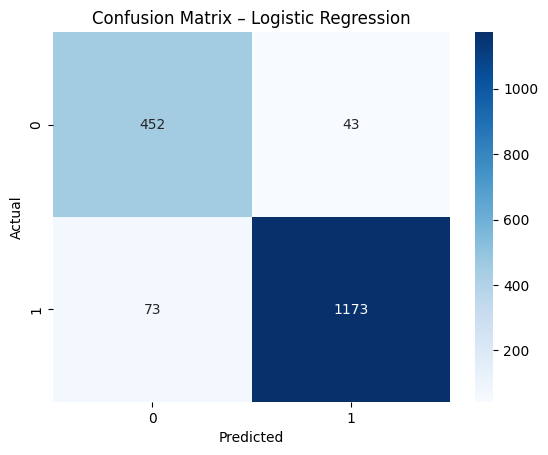

In [ ]:
cm = confusion_matrix(y_test, lr_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


13. Hyperparameter Tuning

In [ ]:
param_grid = {'C': [0.1, 1, 10]}

grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_


14. Feature Importance (Interpretability)

In [ ]:
feature_names = tfidf.get_feature_names_out()
coefficients = best_model.coef_[0]

top_positive = sorted(zip(coefficients, feature_names), reverse=True)[:10]
top_negative = sorted(zip(coefficients, feature_names))[:10]

print("Top Positive Words:", top_positive)
print("Top Negative Words:", top_negative)


Top Positive Words: [(np.float64(9.975729151616815), 'best'), (np.float64(9.962551909850546), 'awesom'), (np.float64(8.895568521124357), 'amaz'), (np.float64(8.732939430188232), 'delici'), (np.float64(7.962342627887292), 'love'), (np.float64(6.968412444861774), 'thank'), (np.float64(6.775280567821089), 'perfect'), (np.float64(6.636596019026864), 'yummi'), (np.float64(6.267954733049845), 'must'), (np.float64(5.977697955913729), 'excel')]
Top Negative Words: [(np.float64(-12.388382727470798), 'worst'), (np.float64(-9.950896181149755), 'pathet'), (np.float64(-7.683334303696366), 'bad'), (np.float64(-7.552541636816284), 'disappoint'), (np.float64(-7.336600748020755), 'poor'), (np.float64(-6.958537275839999), 'horribl'), (np.float64(-5.825505132615185), 'stale'), (np.float64(-5.557757136540085), 'wast'), (np.float64(-5.136731135786424), 'tasteless'), (np.float64(-5.063461469010616), 'ask')]


15. Business Insights - Restaurant Level

In [ ]:
restaurant_sentiment = reviews.groupby('Restaurant')['Sentiment'].mean().sort_values(ascending=False)
restaurant_sentiment.head()


,Sentiment
Restaurant,
AB's - Absolute Barbecues,0.979798
B-Dubs,0.979592
Paradise,0.969697
The Indi Grill,0.968421
Zega - Sheraton Hyderabad Hotel,0.967391


16. Model Saving (Deployment Ready)

In [ ]:
try:
    pickle.dump(best_model, open("zomato_sentiment_model.pkl", "wb"))
    pickle.dump(tfidf, open("tfidf_vectorizer.pkl", "wb"))
    print("Model saved successfully")
except Exception as e:
    print("Model saving failed:", e)


Model saved successfully
